In [20]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/Users/brianbarry/Desktop/computing/personal/galaxybrain')
from galaxybrain import ramsey, ising
from galaxybrain.plot_utils import rc_style, pltlabel, plot_ising_spectra, measure_over_temps, TEMP_COLOR_RANGE, colorcycler
rc_style()

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from matplotlib.colors import ListedColormap as lcmap
import pandas as pd

CRIT_T = 2.26918531421

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Ising model and scaling correlation analysis
Hamiltonian – rate of change of the condition of a dynamic physical system, or total energy in the system – is given by

$$ H = -J\sum_{ij} s_is_j $$

Summing interactions between [4] neighbors, J (Strength of interaction in Joules) is usually 1 <br>
"In the case of an Ising system, instead of moving a particle, we switch the direction of its spin."

In each monte carlo sweep:
- "Propose" a move: (done in aggregate for each particle)
    - if ∆E < 0  (i.e., the move would bring the system to a state of lower energy; this is desired in physical systems), accept it
    - if ∆E > 0, accept move with probability exp(-∆E/kT) where k is Joules per kelvin.

let's try to do this vectorized

Fricke:  multiply every transition probability by 0.1 to avoid undesirable oscillatory regimes

References:
- [matlab code](https://www.asc.ohio-state.edu/braaten.1/statphys/Ising_MatLab.pdf)
- [python - how to find crit temp](https://rajeshrinet.github.io/blog/2014/ising-model/)

In [41]:
tensor= np.array(ising['2.27'])
min(tensor.reshape(tensor.shape[0], -1).shape)

4096

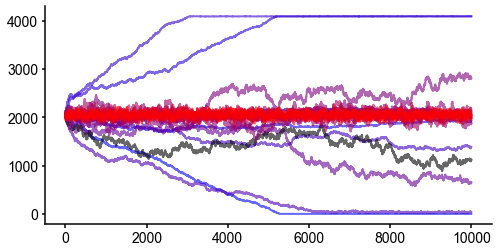

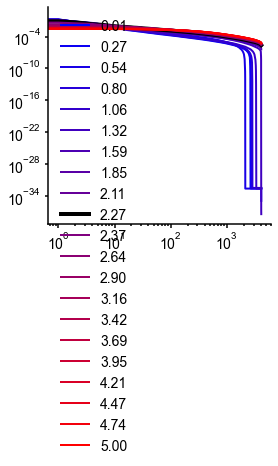

In [35]:
import h5py


evals = h5py.File('/Users/brianbarry/Desktop/computing/personal/galaxybrain/data/experiments/ising_pca/ising_evals.hdf5', 'r') # keys := ['1.97', '2.07', '2.17', '2.27', '2.37', '2.47', '2.57']
ising = h5py.File('/Users/brianbarry/Desktop/computing/personal/galaxybrain/data/spikes/ising.hdf5', 'r') # keys := ['1.97', '2.07', '2.17', '2.27', '2.37', '2.47', '2.57']

colors = colorcycler(['blue', 'red'], len(evals.keys()), default=False)
lws = {'2.27':4}
cs = {'2.27':'k'}
plt.figure(figsize=(8,4))
for t,c in zip(ising, colors):
    plt.plot(np.array(ising[t]).sum(axis=-1).sum(axis=-1), label=t, color=cs.get(t,c), alpha=0.6)

plt.figure()
for t,c in zip(evals, colors):
    plt.loglog(np.array(evals[t]), label=t, color=cs.get(t,c), lw=lws.get(t, 2))
    
plt.legend()

/Users/brianbarry/Desktop/computing/personal/galaxybrain/notebooks/../galaxybrain/ising.py:38: RuntimeWarning: overflow encountered in exp
  p_trans = np.exp(-DeltaE/(k * T)) # according to the Boltzmann distribution. kT is the "characteristic energy"


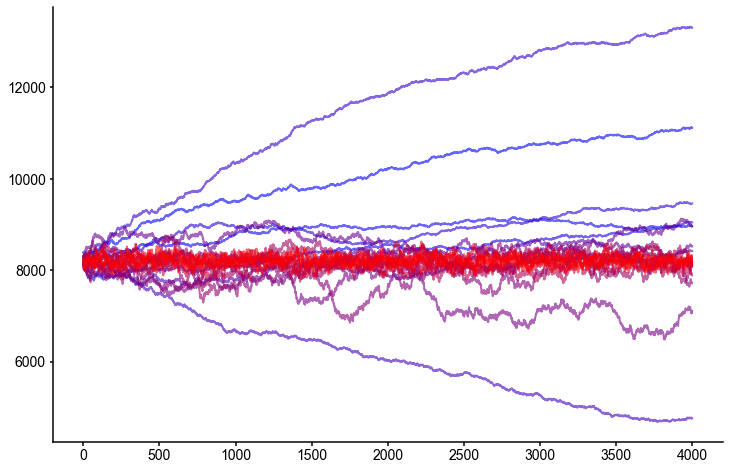

In [21]:
temps = np.linspace(0.01, 5, 20)
history = []
for t in temps:
    series = ising.metro_ising(N=128, T=t, runtime=4000)
    history.append(series)
    
colors = colorcycler(['blue', 'red'], len(temps), default=False)
plt.figure(figsize=(12,8))

for tensor, temp,c in zip(history, temps, colors):
    plt.plot(tensor.sum(axis=-1).sum(axis=-1), label=f'{temp:.2f}', color=c, alpha=0.6)

# plt.legend()

# Final frames

In [22]:
# colors = colorcycler(['blue', 'red'], len(temps), default=False)

# for tensor, temp,c in zip(history, temps, colors):
#     plt.figure(figsize=(4,4))
    
#     plt.imshow(tensor[-1], alpha=0.8)
#     plt.title(f'{temp:.2f}')


# PSD

compute psds

In [25]:
from neurodsp.spectral import compute_spectrum


psds = []
FS       = 1
NPERSEG  = 120 #400
NOVERLAP = NPERSEG/2 #int(.8*NPERSEG)
for tensor, temp in zip(history, temps):
    ts = tensor.sum(axis=-1).sum(axis=-1)
    f, spec = compute_spectrum(ts, fs=FS, nperseg=NPERSEG, noverlap=NOVERLAP)
    psds.append(spec)
    
freqs = f
psds = np.array(psds)

# Spectra

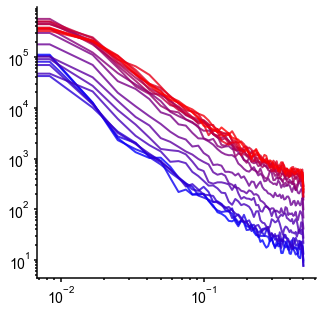

In [9]:

colors = colorcycler(['blue', 'red'], len(temps), default=False)
plt.figure(figsize=(5,5))

for spec, temp,c in zip(psds, temps, colors):
    plt.loglog(freqs, spec, label=f'{temp:.2f}', color=c, alpha=0.8)

# FOOOF (PSD)

In [26]:
from ramsey import fooofy

for f_range in [[0, 0.01], [0.05, 0.4]]:
    plt.figure(figsize=(12,4))
    for i, val in enumerate(fooofy(freqs, psds, f_range)):
    
        plt.subplot(1,3,i+1)
        plt.scatter(temps, val, c=colors, s=30)
        plt.axvline(CRIT_T)


IndexError: index 1 is out of bounds for axis 0 with size 1

<Figure size 864x288 with 0 Axes>

# E Spec

take first n rows (e.g 30  -- > (4000, 30) ) and make sure number of pcs returned is n

In [70]:
from ramsey import pca


especs = []
for tensor in history[:1]:
    data = tensor.reshape(4000, -1)
    especs.append(pca(data, data.shape[0]))


KeyboardInterrupt



In [4]:
from ramsey import pca

data = history[4].reshape(4000, -1)
# es = pca(data, data.shape[0])
data.shape

(4000, 16384)

In [ ]:
for es in especs:
    plt.loglog(es)

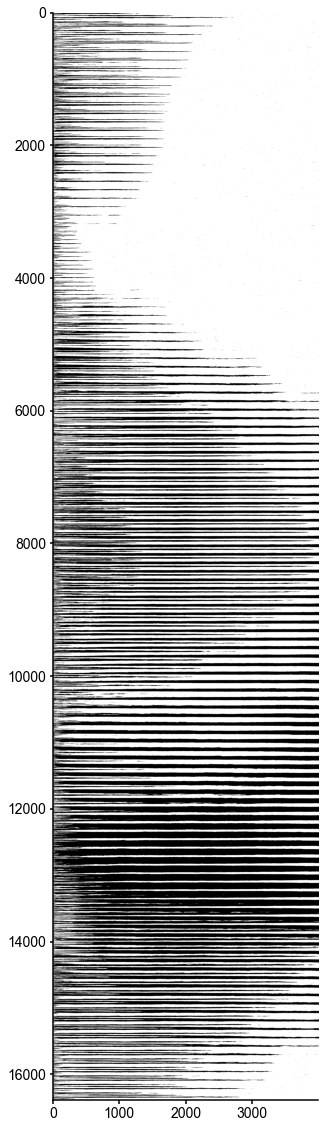

In [5]:

plt.figure(figsize=(10,20))
plt.imshow(history[4].reshape(4000, -1).T)
plt.gray()

# Diagram

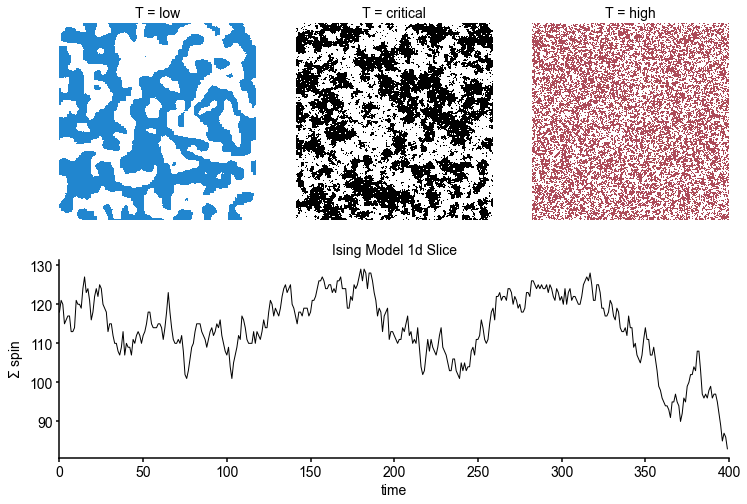

In [19]:
cs = TEMP_COLOR_RANGE[0], 'k', TEMP_COLOR_RANGE[1] #cold, crit, hot
fig = plt.figure(figsize=(12,8))
gs = GridSpec(2,3)
for (i, temp), c in zip(enumerate([0.1, 'critical', 5]), cs):
    # plt.subplot(1,3,i+1)
    ax = fig.add_subplot(gs[0,i])
    grid = ising.metro_ising(N=256, T=temp, runtime=500)
    ax.imshow(grid[499], cmap=lcmap(['w',c])) # plot last frame
    title_map = {0.1:'low', 'critical':'critical', 5:'high'}
    plt.title(f'T = {title_map[temp]}', fontsize=14)
    ax.axis('off')
    if temp == 'critical':
        ax = fig.add_subplot(gs[1,:])
        ising_raster_slice = pd.DataFrame(grid[100:][:,178]) # shape (400, 256)

        ax.plot(np.sum(ising_raster_slice.T), c, lw=1)
        plt.xlim([0,400])
        pltlabel('Ising Model 1d Slice', 'time', r'$\Sigma$ spin')
    
plt.savefig('../fig/ising/grid_samples.png', bbox_inches='tight', pad_inches=0.0, dpi=400)

# Data from cluster

Iterated 5 times for each temperature in: 0.50, 1.00, 1.27, 1.47, 1.67, 1.87, 2.07, 2.27, 2.47, 2.67, 2.87, 3.07, 3.27, 5.00

In [20]:
from galaxybrain.data_utils import load_results

sim_data = load_results('../data/experiments/expSIM2', kind='sim')
all_temps = [k for k in sim_data if k != 'meta']

{'n_iters': 95, 'n_pc': 0.8, 'f_range': [0, 0.4]}


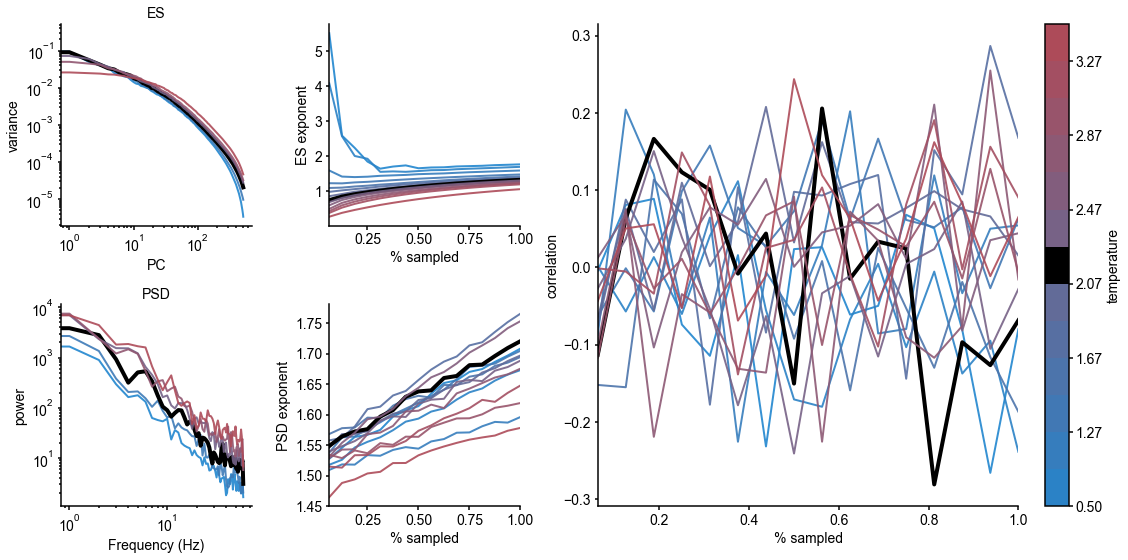

In [132]:
sample_temps = ['1.67', '1.87', '2.27', '2.67', '3.07', '5.00'] # avoid big drop off with very low temps

fig = plt.figure(figsize=(16,8))
gs = GridSpec(2,3, width_ratios=[1,1, 2.75])

for (i, spec), labels in zip(enumerate(['eigs', 'pows']), 
                           [['ES','PC', 'variance'], ['PSD','Frequency (Hz)', 'power']]):
    ax = fig.add_subplot(gs[i, 0])
    plot_ising_spectra(sim_data, spec, sample_temps, ax=ax)
    pltlabel(*labels)

for (i, spec), labels in zip(enumerate(['pca_m', 'ft_m']), 
                           [['','% sampled', 'ES exponent'], ['','% sampled', 'PSD exponent']]):
    ax = fig.add_subplot(gs[i, 1])
    measure_over_temps(sim_data, spec, all_temps, ax=ax)
    pltlabel(*labels)
    
ax = fig.add_subplot(gs[:,2])
measure_over_temps(sim_data, 'pearson_corr', all_temps, ax, colorbar=True)
pltlabel('', '% sampled', 'correlation')
fig.tight_layout()

plt.savefig('../fig/ising/specs_corr.png', bbox_inches='tight', pad_inches=0.0, dpi=400)